In [ ]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def load_injective_norms(json_path, field="inj_over_l2"):
    """
    Load injective norms from the JSON file produced by Injective_Norm_descent.py.

    Parameters
    ----------
    json_path : str or Path
        Path to JSON file.
    field : str
        Which field to use:
          - "inj_raw"      : approximate ||T||_inj
          - "inj_over_l2"  : approximate ||T||_inj / ||T||_2

    Returns
    -------
    norms : np.ndarray
    metadata : dict
    """
    json_path = Path(json_path)
    with open(json_path, "r") as f:
        data = json.load(f)

    if field not in data:
        raise KeyError(f"JSON file does not contain key '{field}'.")

    norms = np.asarray(data[field], dtype=float)

    metadata = {
        "p": data.get("p", None),
        "d": data.get("d", None),
        "n_samples": data.get("n_samples", len(norms)),
        "complex_valued": data.get("complex_valued", None),
        "timestamp": data.get("timestamp", None),
    }

    return norms, metadata

def gaussian_normalization_factor(p: int, d: int, include_sqrt_p: bool = True) -> float:
    """
    Normalization:

        factor_base(d,p) = sqrt( d * p! / ( 2 * (d - p) * p ) )

    For the antisymmetric an extra sqrt(p),
    so the total factor is:

        factor_total = factor_base * sqrt(p)   (if include_sqrt_p=True)
    """
    if p is None or d is None:
        raise ValueError("Need both p and d for normalization.")
    if d <= p or p <= 0:
        raise ValueError(f"Normalization requires d > p >= 1, got p={p}, d={d}.")

    factor_base = math.sqrt(d * math.factorial(p) / (2.0 * (d - p) * p))
    if include_sqrt_p:
        factor_base *= math.sqrt(p)
    return factor_base


def plot_injective_norms(
    norms,
    metadata=None,
    save_path=None,
    normalize=True,
    include_sqrt_p=True,
):
    """
    Plot:
      - (optionally normalized) injective norm of each run (sample index on x axis),
      - mean as a horizontal line,
      - mean ± std as a shaded band.

    If normalize=True, we use the following normalization:

        scaled_norms = norms * factor(d,p)

    where factor(d,p) = sqrt(d * p! / (2 * (d - p) * p)) * (sqrt(p) if include_sqrt_p).
    """
    norms = np.asarray(norms, dtype=float)

    raw_mean = norms.mean()
    raw_std = norms.std(ddof=0)

    # Apply normalization factor if requested
    if normalize and metadata is not None:
        p = metadata.get("p", None)
        d = metadata.get("d", None)
        factor = gaussian_normalization_factor(p, d, include_sqrt_p=include_sqrt_p)
        scaled_norms = norms * factor
        used_norms = scaled_norms
        norm_label = "normalized injective norm"
    else:
        factor = None
        used_norms = norms
        norm_label = "injective norm"

    mean = used_norms.mean()
    std = used_norms.std(ddof=0)

    # For debugging / sanity checks
    print("Raw mean/std:", raw_mean, raw_std)
    if factor is not None:
        print(f"Normalization factor (p={p}, d={d}, include_sqrt_p={include_sqrt_p}): {factor}")
        print("Normalized mean/std:", mean, std)

    n = len(used_norms)
    x = np.arange(1, n + 1)

    plt.figure(figsize=(8, 5))

    # individual norms
    plt.plot(x, used_norms, "o-", label=norm_label, alpha=0.7)

    # mean line
    plt.axhline(mean, color="red", linestyle="--", label=f"mean = {mean:.4f}")

    # mean ± std band
    plt.fill_between(
        x,
        mean - std,
        mean + std,
        color="red",
        alpha=0.15,
        label=f"±1 std = {std:.4f}",
    )

    title_parts = ["Injective norms"]
    if metadata is not None:
        p = metadata.get("p", None)
        d = metadata.get("d", None)
        complex_flag = metadata.get("complex_valued", None)
        if p is not None and d is not None:
            title_parts.append(f"p = {p}, d = {d}")
        if complex_flag is not None:
            title_parts.append("complex" if complex_flag else "real")
        if normalize:
            title_parts.append("Gauss-normalized")

    plt.title(" | ".join(title_parts))
    plt.xlabel("sample index")
    plt.ylabel(norm_label)
    plt.grid(True, alpha=0.3)
    plt.legend()

    if save_path is not None:
        save_path = Path(save_path)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Plot saved to {save_path}")

    plt.show()



# ---- load all JSONs in a folder and aggregate by dimension ----

def load_folder_stats(
    folder: str | Path,
    mode: str = "state_gauss",
    include_sqrt_p: bool = True,
):
    """
    Load all JSON files from a folder (format from Injective_Norm_descent.py)
    and aggregate the chosen quantity by dimension d.

    Parameters
    ----------
    folder : str or Path
        Folder containing JSON files.
    mode : str
        One of:
          - "raw"        : use inj_raw                      ≈ ||T||_inj
          - "raw_gauss"  : inj_raw * gaussian_factor(d,p)
          - "state"      : use inj_over_l2                  ≈ ||T||_inj / ||T||_2
          - "state_gauss": inj_over_l2 * gaussian_factor(d,p)
    include_sqrt_p : bool
        If mode ends with "_gauss", choose whether the Gaussian factor includes sqrt(p).

    Returns
    -------
    dims_sorted : np.ndarray of unique dimensions
    means       : np.ndarray of mean values for each dimension
    stds        : np.ndarray of std values for each dimension
    meta_info   : dict with p, complex_valued, samples_per_d
    """
    folder = Path(folder)
    json_files = sorted(folder.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in folder: {folder}")

    values_by_d: dict[int, list[np.ndarray]] = {}
    samples_by_d: dict[int, int] = {}

    p_global = None
    complex_global = None

    for jf in json_files:
        with open(jf, "r") as f:
            data = json.load(f)

        p = data.get("p", None)
        d = data.get("d", None)
        cplx = data.get("complex_valued", None)

        if p_global is None:
            p_global = p
            complex_global = cplx
        else:
            if p != p_global:
                raise ValueError(f"Inconsistent p: got {p} in file {jf}, expected {p_global}.")
            if cplx != complex_global:
                raise ValueError(
                    f"Inconsistent complex_valued: got {cplx} in file {jf}, expected {complex_global}."
                )

        # Choose base field from JSON
        if mode in ("raw", "raw_gauss"):
            base = np.asarray(data["inj_raw"], dtype=float)
        elif mode in ("state", "state_gauss"):
            base = np.asarray(data["inj_over_l2"], dtype=float)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Apply Gaussian factor if requested
        if mode.endswith("_gauss"):
            factor = gaussian_normalization_factor(p, d, include_sqrt_p=include_sqrt_p)
            vals = base * factor
        else:
            vals = base

        values_by_d.setdefault(d, []).append(vals)
        samples_by_d[d] = samples_by_d.get(d, 0) + len(vals)

    # Concatenate all runs per dimension and compute statistics
    dims = sorted(values_by_d.keys())
    means = []
    stds = []

    for d in dims:
        arr = np.concatenate(values_by_d[d])
        means.append(arr.mean())
        stds.append(arr.std(ddof=0))

    dims = np.asarray(dims, dtype=int)
    means = np.asarray(means, dtype=float)
    stds = np.asarray(stds, dtype=float)

    meta_info = {
        "p": p_global,
        "complex_valued": complex_global,
        "samples_per_d": samples_by_d,
    }

    return dims, means, stds, meta_info


# ---- Main plotting for folder ----

def plot_injective_vs_dimension(
    folder: str | Path,
    mode: str = "raw_gauss",
    include_sqrt_p: bool = True,
    save_path: str | Path | None = None,
):
    """
    Make an injective norm vs dimension plot from all JSON files in a folder.

    Parameters
    ----------
    folder : str or Path
        Folder containing JSON files from Injective_Norm_descent.py.
    mode : str
        Normalization mode
        "raw"        : plot ||T||_inj
        "raw_gauss"  : plot ||T||_inj * Gaussian factor(d,p)
        "state"      : plot ||T||_inj / ||T||_2
        "state_gauss": plot (||T||_inj / ||T||_2) * Gaussian factor(d,p)
    include_sqrt_p : bool
        Only used if mode ends with "_gauss".
    save_path : str or Path or None
        If not None, save figure to this path.
    """
    dims, means, stds, meta = load_folder_stats(
        folder, mode=mode, include_sqrt_p=include_sqrt_p
    )

    p = meta["p"]
    cplx = meta["complex_valued"]

    if mode == "raw":
        ylabel = r"$\|T\|_{\mathrm{inj}}$"
        desc = "raw injective norm"
    elif mode == "raw_gauss":
        ylabel = r"Gauss-normalized $\|T\|_{\mathrm{inj}}$"
        desc = "raw + Gauss factor"
    elif mode == "state":
        ylabel = r"$\|T\|_{\mathrm{inj}} / \|T\|_2$"
        desc = "normalized by $\\|T\\|_2$"
    elif mode == "state_gauss":
        ylabel = r"Gauss-normalized $\|T\|_{\mathrm{inj}} / \|T\|_2$"
        desc = "state + Gauss factor"
    else:
        ylabel = "value"
        desc = mode

    plt.figure(figsize=(7, 5))
    plt.errorbar(
        dims,
        means,
        yerr=stds,
        fmt="o-",
        capsize=4,
        label="mean ± std",
    )

    title_parts = [f"p = {p}", f"{'complex' if cplx else 'real'} antisymmetric tensors", desc]
    plt.title(" | ".join(title_parts))
    plt.xlabel("dimension d")
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.legend()

    if save_path is not None:
        save_path = Path(save_path)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved figure to {save_path}")

    plt.show()

    print("Dimensions:", dims)
    print("Means:", means)
    print("Stds:", stds)
    print("Samples per d:", meta["samples_per_d"])


Raw mean/std: 0.009348447213913022 0.00011168936631198866
Normalization factor (p=4, d=50, include_sqrt_p=False): 1.805787796286538
Normalized mean/std: 0.016881311893113024 0.00020168729466116584


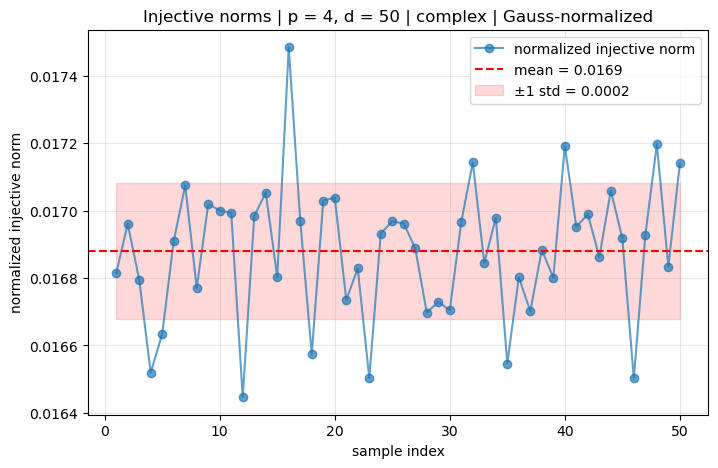

Raw mean/std: 0.8975498712062836 0.010664702974996526
Normalization factor (p=4, d=50, include_sqrt_p=True): 3.611575592573076
Normalized mean/std: 3.241569207965722 0.03851638096653894


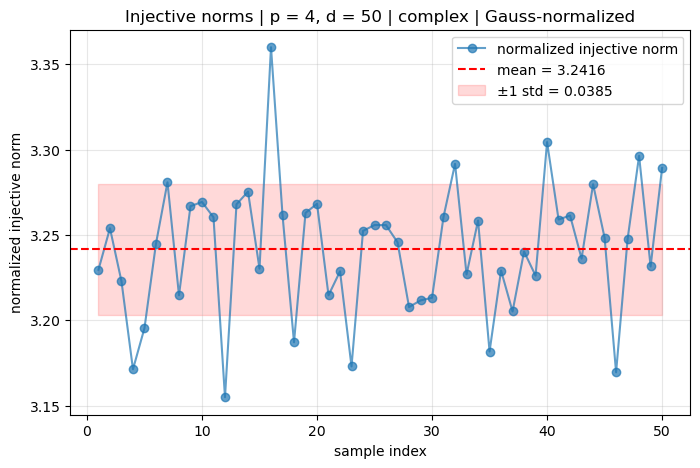

In [27]:
json_file = "antisym_p4_d50_n50_complexTrue.json"

# 1) Plot ||T||_inj / ||T||_2 
norms, meta = load_injective_norms(json_file, field="inj_over_l2")
plot_injective_norms(norms, metadata=meta, normalize=True, include_sqrt_p=False)

# 2) Plot raw ||T||_inj 
norms_raw, meta_raw = load_injective_norms(json_file, field="inj_raw")
plot_injective_norms(norms_raw, metadata=meta_raw, normalize=True, include_sqrt_p=True)


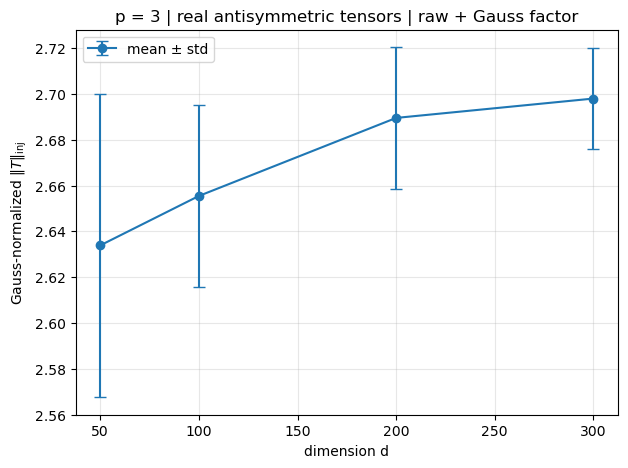

Dimensions: [ 50 100 200 300]
Means: [2.63387158 2.65546186 2.68955067 2.69800588]
Stds: [0.06631955 0.03983754 0.03087766 0.02201997]
Samples per d: {100: 50, 200: 50, 300: 50, 50: 50}


In [28]:
folder = "results_p3"  # the folder with JSONs

plot_injective_vs_dimension(folder, mode="raw_gauss", include_sqrt_p=True)